#  1.  Circle inside Large Circle

#### Fernanda Weiss
#### Fabián Fernandez

Lo siguiente es un problema de clasificación, en donde los datos a clasificar son linealemente inseparables, por lo que se utilizarán modelos no-lineales. Es inseparable ya que al tener datos de entrada $x \in R^2$ y su etiqueta correspondiente $y \in \{−1, 1\}$, no existe un vector de pesos $w \in R^2$ y $b \in R$ tal que $y(w^Tx + b) \geq \rho > 0$

### a) Crear dataset de entrenamiento y prueba

Se crean dos conjuntos de datos, uno de entrenamiento y otro de prueba, cada uno contiene 1.000 datos de la forma  $\{(x_1, y_1), . . . ,(x_n, y_n)\}$, $x_i ∈ R^2$, $y_i \in \{0, 1\}$, con una distribución de probabilidad que refleje la configuración linealmente inseparable.

Además se agrega un 5% de ruido a los datos, generando nuevos $x_i$ cercanos a la frontera.

In [1]:
import numpy as np
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split
def do_circles(n=2000,noisy_n=0.05):
    generator = check_random_state(10)
    linspace = np.linspace(0, 2 * np.pi, n // 2 + 1)[:-1]
    outer_circ_x = np.cos(linspace)
    outer_circ_y = np.sin(linspace)
    inner_circ_x = outer_circ_x * .3
    inner_circ_y = outer_circ_y * .3
    X = np.vstack((np.append(outer_circ_x, inner_circ_x),np.append(outer_circ_y, inner_circ_y))).T
    
    y = np.hstack([np.zeros(n // 2, dtype=np.intp), np.ones(n // 2, dtype=np.intp)])
    
    X += generator.normal(scale=noisy_n, size=X.shape)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
    return X_train,y_train,X_test,y_test

In [2]:
X_no_noisy,y_no_noisy,X_no_noisy_test,y_no_noisy_test = do_circles(2000, 0)

In [3]:
import matplotlib.pyplot as plt
def visualize(x,y,title=""):
    fig = plt.figure(figsize=(12,6))
    plt.scatter(x[:,0], x[:,1], s=50, c=y, cmap=plt.cm.winter)
    h = .02 # step size in the mesh
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    plt.title(title)
    plt.show()

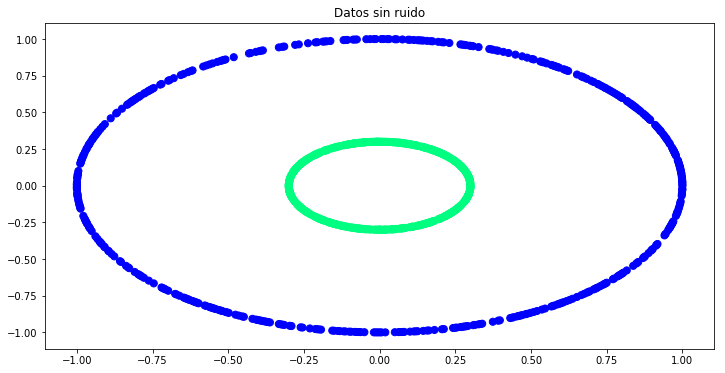

In [4]:
visualize(X_no_noisy, y_no_noisy, "Datos sin ruido")

In [5]:
X_train,y_train,X_test,y_test = do_circles(2000, 0.05)

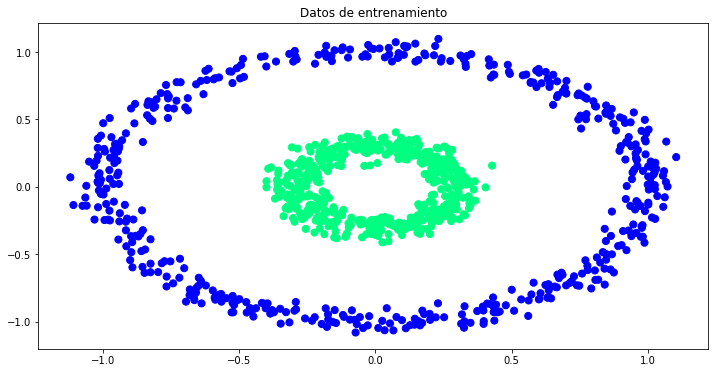

In [6]:
visualize(X_train, y_train, "Datos de entrenamiento")

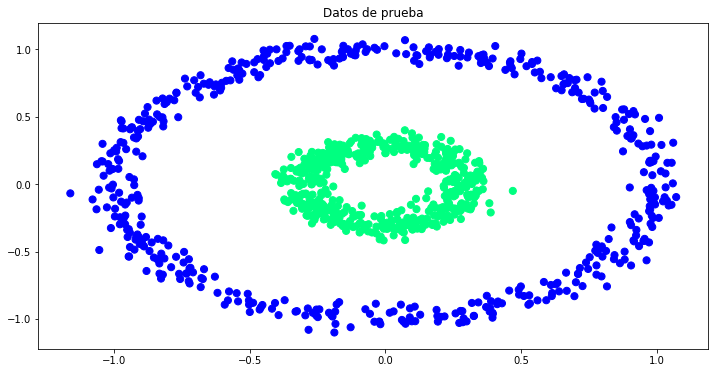

In [7]:
visualize(X_test, y_test, "Datos de prueba")

Mediante la primera gráfica se puede ver como sería un dataset generado sin ruido. Luego se muestra el dataset de entrenamiento y prueba, respectivamente, con el 5% de ruido inducido.

Para lo que sigue, se utilizará la siguiente función para graficar las fronteras de clasificación en base a la probabilidad, definida por un algoritmo, de un ejemplo a pertenecer a una clase en particular.

In [8]:
def plot_classifier(clf,X_train,Y_train,X_test,Y_test,model_type):
    f, axis = plt.subplots(1, 1, sharex='col', sharey='row',figsize=(12, 8))
    axis.scatter(X_train[:,0],X_train[:,1],s=30,c=Y_train,zorder=10,cmap='cool')
    axis.scatter(X_test[:,0],X_test[:,1],s=20,c=Y_test,zorder=10,cmap='Greys')
    XX, YY = np.mgrid[-2:2:200j, -2:2:200j]
    if model_type == 'tree':
        Z = clf.predict_proba(np.c_[XX.ravel(), YY.ravel()])[:,0]
    elif model_type == 'ann':
        Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])
    else: raise ValueError('model type not supported')
    Z = Z.reshape(XX.shape)
    Zplot = Z >= 0.5
    axis.pcolormesh(XX, YY, Zplot ,cmap='YlGn')
    axis.contour(XX, YY, Z, alpha=1, colors=["k", "k", "k"], linestyles=["--", "-", "--"],
    levels=[-2, 0, 2])
    plt.show()

### b) Red neuronal artificial con una neurona

Se intenta resolver el problema de clasificación con una red neuronal artificial con solo una neurona, es decir, sin capas escondidas. Investigando la librerías que implementa las redes neuronales, hallamos las siguientes funciones de activación, optimizadores y funciones de pérdida que posee: 

Parámetros keras: No se usará regularizador

* Layer: Dense
    * units: primer numero que se pone, indica la dimensionalidad del output
    * activation: funcion de activación que se usa, sin esto se usara a(x)=x. https://keras.io/activations/
       Existe:
       * linear
       * sigmoid
       * hard_sigmoid
       * tanh
       * relu
       * softsign
       * softplus
       * selu
       * elu
       * softmax
    * kernel_initializer: Initializer for the kernel weights https://keras.io/initializers/
    
    
* Optimizadores disponibles: https://keras.io/optimizers/
    * SGD
    * RMSprop
    * Adagrad
    * Adam
    * Adamax
    * Nadam
    * TFOptimizer
   
* Funciones de perdida: https://keras.io/losses/
    * mean_squared_error
    * mean_absolute_error
    * mean_absolute_percentage_error
    * mean_squared_logarithmic_error
    * squared_hinge
    * hinge
    * categorical_hinge
    * logcosh
    * categorical_crossentropy
    * sparse_categorical_crossentropy
    * binary_crossentropy
    * kullback_leibler_divergence
    * poisson
    * cosine_proximity

En esta ocasión, el optimizador a utilizar en la siguiente sección será un gradiente descendente estocástico (SGD). En una primera instancia se aborda el problema con una capa de entrada con función de activación ReLU (rectified linear unit) y una inicialización de pesos con distribución uniforme y una capa de salida con una función de activación sigmoid. La función de perdida que se utilizará para el siguiente modelo será la Cross entropy binaria, esto es por que es un problema de clasificación con sólo 2 clases.

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

n_h=1
model_sgd_1_relu = Sequential()
model_sgd_1_relu.add(Dense(1, input_dim=X_train.shape[1], kernel_initializer='uniform', activation='relu'))
model_sgd_1_relu.add(Dense(n_h, init='uniform', activation='sigmoid'))
model_sgd_1_relu.compile(optimizer=SGD(lr=1), loss='binary_crossentropy', metrics=['accuracy', 'mae', 'mse'])
model_sgd_1_relu.fit(X_train, y_train, epochs=50, batch_size=100, verbose=1)
scores = model_sgd_1_relu.evaluate(X_test, y_test)


Using TensorFlow backend.
c:\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  


Epoch 1/50
1000/1000 [==============================] - 0s 329us/step - loss: 0.6933 - acc: 0.5060 - mean_absolute_error: 0.5001 - mean_squared_error: 0.2501
Epoch 2/50
1000/1000 [==============================] - 0s 26us/step - loss: 0.6933 - acc: 0.5010 - mean_absolute_error: 0.4997 - mean_squared_error: 0.2501
Epoch 3/50
1000/1000 [==============================] - 0s 20us/step - loss: 0.6945 - acc: 0.4930 - mean_absolute_error: 0.5004 - mean_squared_error: 0.2507
Epoch 4/50
1000/1000 [==============================] - 0s 25us/step - loss: 0.6934 - acc: 0.5230 - mean_absolute_error: 0.5000 - mean_squared_error: 0.2501
Epoch 5/50
1000/1000 [==============================] - 0s 21us/step - loss: 0.6928 - acc: 0.5250 - mean_absolute_error: 0.4988 - mean_squared_error: 0.2498
Epoch 6/50
1000/1000 [==============================] - 0s 19us/step - loss: 0.6905 - acc: 0.5660 - mean_absolute_error: 0.4985 - mean_squared_error: 0.2487
Epoch 7/50
1000/1000 [==============================] - 0

In [10]:
test_acc = scores[1]
print(test_acc)

0.67


Con esta configuración se obtiene un *accuracy* de 67,2% , un valor bajo considerando que es clasificación binaria y que se está utilizando una red neuronal, pero en sí, como tiene una sóla neurona, es como un modelo de regresión logística ordinario, esto es, no se están aprovechando toda la capacidad que tiene este modelo. Se variarán algunos parámetros para comprobar que no es el valor de los parámetros el que influye, sino la arquitectura seleccionada.

c:\anaconda3\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


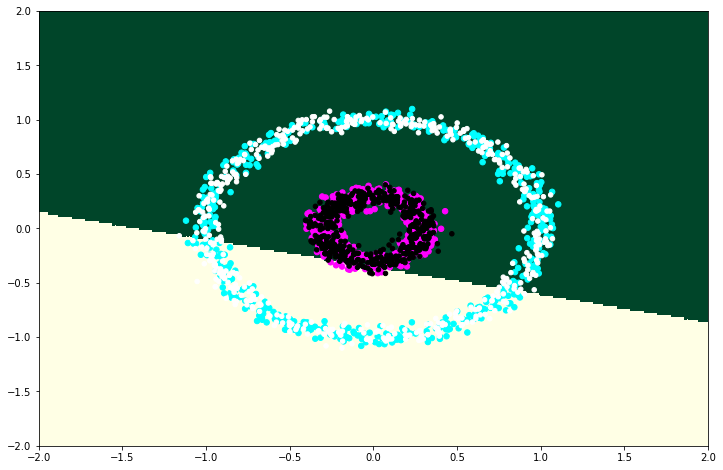

In [11]:
plot_classifier(model_sgd_1_relu,X_train,y_train,X_test,y_test,model_type = 'ann')

En este gráfico, se puede visualizar como actúa la red con la configuración explicada anteriormente, funciona mal, como era de esperar. El área verde indica cómo predice la red neuronal, se aprecia claramente que es una frontera lineal y por esto el *bajo* valor de *accuracy* para la clasificación.

A continuación se prueba variando la tasa de aprendizaje del optimizador SGD:

In [12]:
n_h=1
model_sgd_01_relu = Sequential()

model_sgd_01_relu.add(Dense(1, input_dim=X_train.shape[1], kernel_initializer='uniform', activation='relu'))
model_sgd_01_relu.add(Dense(n_h, init='uniform', activation='sigmoid'))

model_sgd_01_relu.compile(optimizer=SGD(lr=0.1), loss='binary_crossentropy', metrics=['accuracy', 'mae', 'mse'])
model_sgd_01_relu.fit(X_train, y_train, epochs=50, batch_size=100, verbose=1)
scores = model_sgd_01_relu.evaluate(X_test, y_test)


c:\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  """


Epoch 1/50
1000/1000 [==============================] - 1s 1ms/step - loss: 0.6933 - acc: 0.4840 - mean_absolute_error: 0.5001 - mean_squared_error: 0.2501
Epoch 2/50
1000/1000 [==============================] - 0s 86us/step - loss: 0.6933 - acc: 0.4930 - mean_absolute_error: 0.5001 - mean_squared_error: 0.2501
Epoch 3/50
1000/1000 [==============================] - 0s 57us/step - loss: 0.6932 - acc: 0.5070 - mean_absolute_error: 0.5000 - mean_squared_error: 0.2500
Epoch 4/50
1000/1000 [==============================] - 0s 82us/step - loss: 0.6932 - acc: 0.5070 - mean_absolute_error: 0.5000 - mean_squared_error: 0.2500
Epoch 5/50
1000/1000 [==============================] - 0s 58us/step - loss: 0.6931 - acc: 0.5070 - mean_absolute_error: 0.4999 - mean_squared_error: 0.2500
Epoch 6/50
1000/1000 [==============================] - 0s 61us/step - loss: 0.6932 - acc: 0.5070 - mean_absolute_error: 0.5000 - mean_squared_error: 0.2500
Epoch 7/50
1000/1000 [==============================] - 0s 

In [13]:
test_acc = scores[1]
print(test_acc)

0.493


c:\anaconda3\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


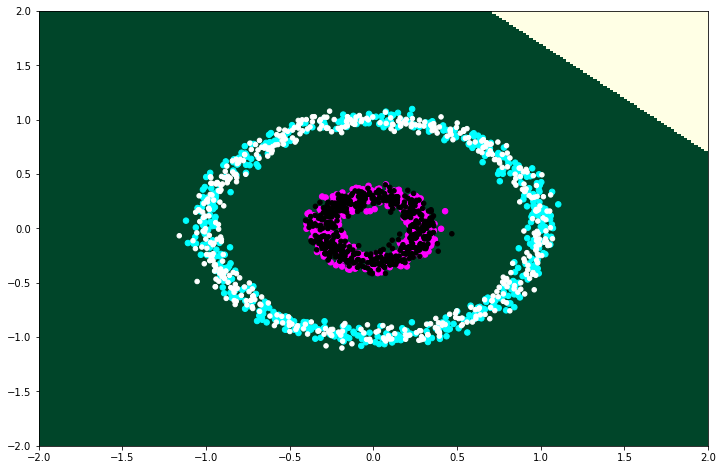

In [14]:
plot_classifier(model_sgd_01_relu,X_train,y_train,X_test,y_test,model_type = 'ann')

Los resultados de la función de pérdida con el accuracy se intercambian, el error cuadrático aumenta un poco y el gráfico permanece similar sólo con un cambio de orientación. Sin embargo, sigue funcionando mal, además el valor de accuracy obtenido en el conjunto de test es menor que el valor obtenido con lr = 1 .

Luego, se prueba cambiando la función de activación de la capa de entrada por una función elu, y volviendo a una tasa de aprendizaje de la SGD de 1.

In [15]:
n_h=1
model_sgd_1_sigmoid = Sequential()

model_sgd_1_sigmoid.add(Dense(1, input_dim=X_train.shape[1], kernel_initializer='uniform', activation='elu'))
model_sgd_1_sigmoid.add(Dense(n_h, init='uniform', activation='sigmoid'))

model_sgd_1_sigmoid.compile(optimizer=SGD(lr=1), loss='binary_crossentropy', metrics=['accuracy', 'mae', 'mse'])
model_sgd_1_sigmoid.fit(X_train, y_train, epochs=50, batch_size=100, verbose=1)
scores = model_sgd_1_sigmoid.evaluate(X_test, y_test)
test_acc = scores[1]

c:\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  """


Epoch 1/50
1000/1000 [==============================] - 0s 462us/step - loss: 0.6939 - acc: 0.5100 - mean_absolute_error: 0.5002 - mean_squared_error: 0.2504
Epoch 2/50
1000/1000 [==============================] - 0s 22us/step - loss: 0.6941 - acc: 0.4910 - mean_absolute_error: 0.5004 - mean_squared_error: 0.2505
Epoch 3/50
1000/1000 [==============================] - 0s 22us/step - loss: 0.6951 - acc: 0.4780 - mean_absolute_error: 0.5006 - mean_squared_error: 0.2510
Epoch 4/50
1000/1000 [==============================] - 0s 20us/step - loss: 0.6935 - acc: 0.4950 - mean_absolute_error: 0.5000 - mean_squared_error: 0.2502
Epoch 5/50
1000/1000 [==============================] - 0s 32us/step - loss: 0.6942 - acc: 0.4960 - mean_absolute_error: 0.5004 - mean_squared_error: 0.2505
Epoch 6/50
1000/1000 [==============================] - 0s 27us/step - loss: 0.6942 - acc: 0.4960 - mean_absolute_error: 0.5002 - mean_squared_error: 0.2505
Epoch 7/50
1000/1000 [==============================] - 0

c:\anaconda3\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


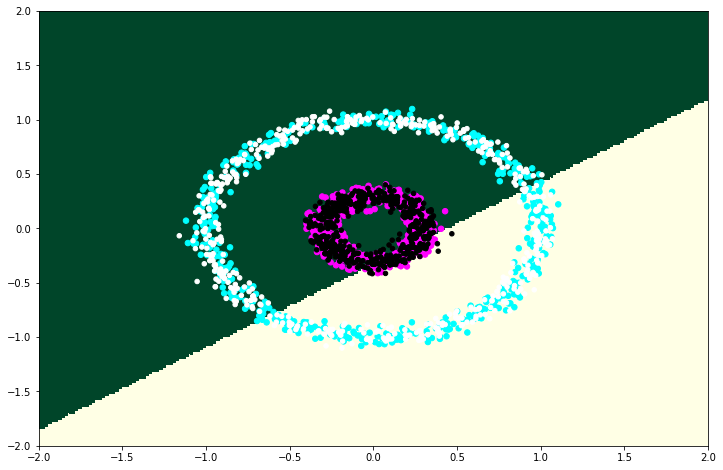

In [16]:
plot_classifier(model_sgd_1_sigmoid,X_train,y_train,X_test,y_test,model_type = 'ann')

In [17]:
print(test_acc)

0.608


Se puede observar como las métricas se mantienen en general muy parecidas, en general son bastante bajas.

In [18]:
n_h=1
model_sgd_01_sigmoid = Sequential()

model_sgd_01_sigmoid.add(Dense(1, input_dim=X_train.shape[1], kernel_initializer='uniform', activation='selu'))
model_sgd_01_sigmoid.add(Dense(n_h, init='uniform', activation='sigmoid'))

model_sgd_01_sigmoid.compile(optimizer=SGD(lr=0.1), loss='binary_crossentropy', metrics=['accuracy', 'mae', 'mse'])
model_sgd_01_sigmoid.fit(X_train, y_train, epochs=50, batch_size=100, verbose=1)
scores = model_sgd_01_sigmoid.evaluate(X_test, y_test)
test_acc = scores[1]

c:\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  """


Epoch 1/50
1000/1000 [==============================] - 1s 1ms/step - loss: 0.6931 - acc: 0.4870 - mean_absolute_error: 0.5000 - mean_squared_error: 0.2500
Epoch 2/50
1000/1000 [==============================] - 0s 81us/step - loss: 0.6931 - acc: 0.5150 - mean_absolute_error: 0.5000 - mean_squared_error: 0.2500
Epoch 3/50
1000/1000 [==============================] - 0s 95us/step - loss: 0.6930 - acc: 0.5070 - mean_absolute_error: 0.4999 - mean_squared_error: 0.2499
Epoch 4/50
1000/1000 [==============================] - 0s 59us/step - loss: 0.6930 - acc: 0.5070 - mean_absolute_error: 0.4999 - mean_squared_error: 0.2499
Epoch 5/50
1000/1000 [==============================] - 0s 81us/step - loss: 0.6930 - acc: 0.5270 - mean_absolute_error: 0.4999 - mean_squared_error: 0.2499
Epoch 6/50
1000/1000 [==============================] - 0s 76us/step - loss: 0.6930 - acc: 0.5070 - mean_absolute_error: 0.4999 - mean_squared_error: 0.2499
Epoch 7/50
1000/1000 [==============================] - 0s 

c:\anaconda3\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


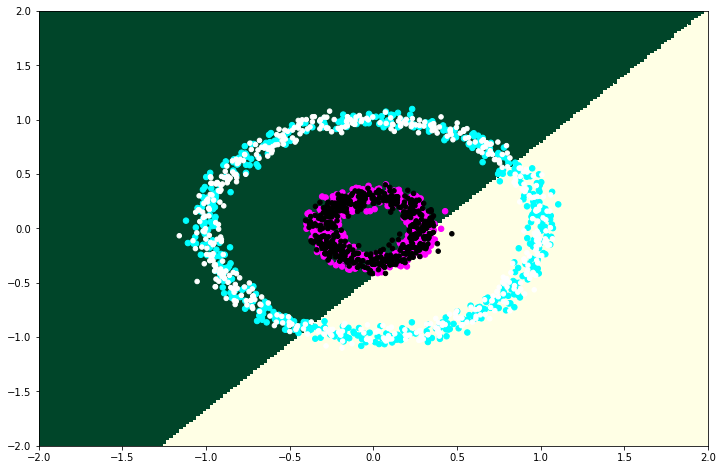

In [19]:
plot_classifier(model_sgd_01_sigmoid,X_train,y_train,X_test,y_test,model_type = 'ann')

In [20]:
print(test_acc)

0.622


Con una función de activación selu en la capa de entrada se ve que mediante las metricas que no mejora mucho.
Con lo que se pudo experimentar, pese a cambiar algunas funciones de activación y tasas de aprendizaje, una única neurona no puede clasificar satisfactoriamente un problema linealmente inseparable.

### c) Red neuronal artificial con una capa escondida

A continuación evaluaremos experimentalmente si una red neuronal con 1 capa escondida puede resolver el problema de clasificación satisfactoriamente. Se cambiará el número de neuronas de esta entre 2 y 32 en potencias de 2 para graficar el error de entrenamiento y pruebas.

Gráfico con 2 neuronas en la capa escondida:


c:\anaconda3\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


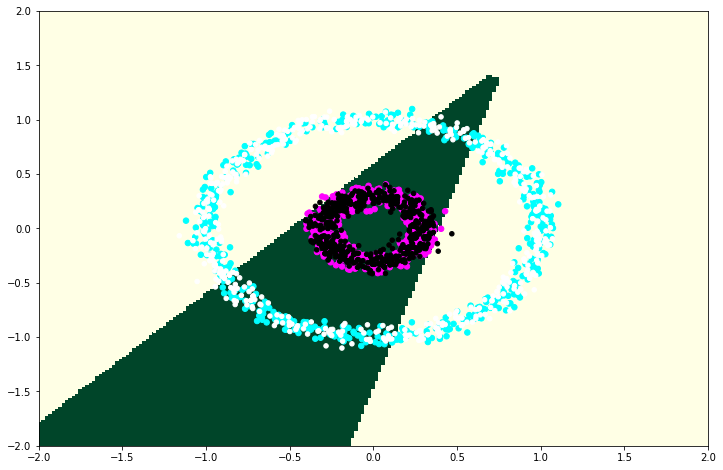

Gráfico con 4 neuronas en la capa escondida:


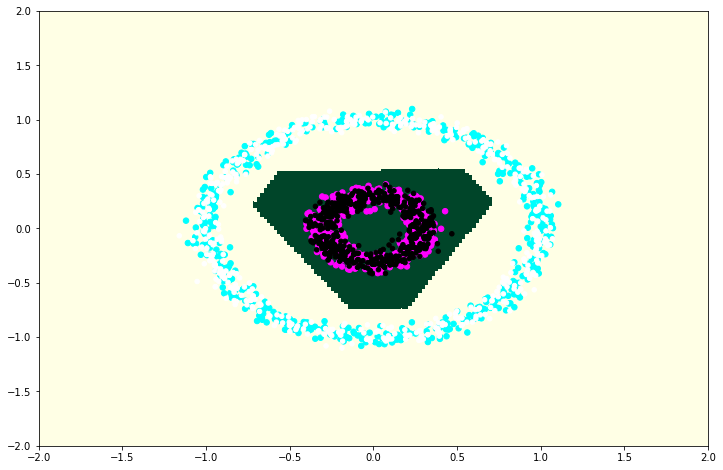

Gráfico con 8 neuronas en la capa escondida:


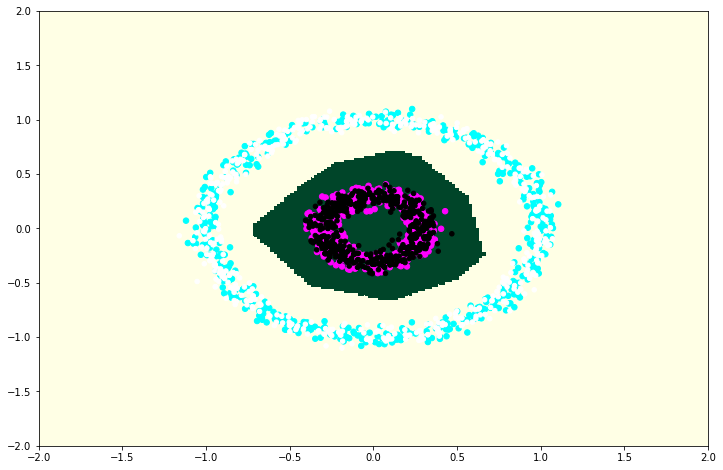

Gráfico con 16 neuronas en la capa escondida:


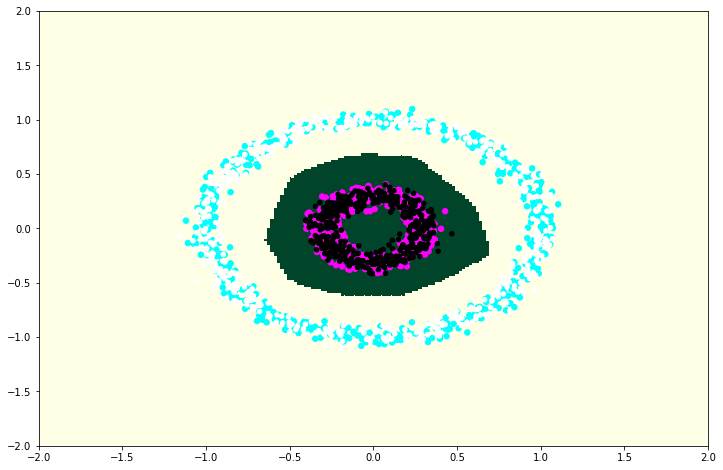

Gráfico con 32 neuronas en la capa escondida:


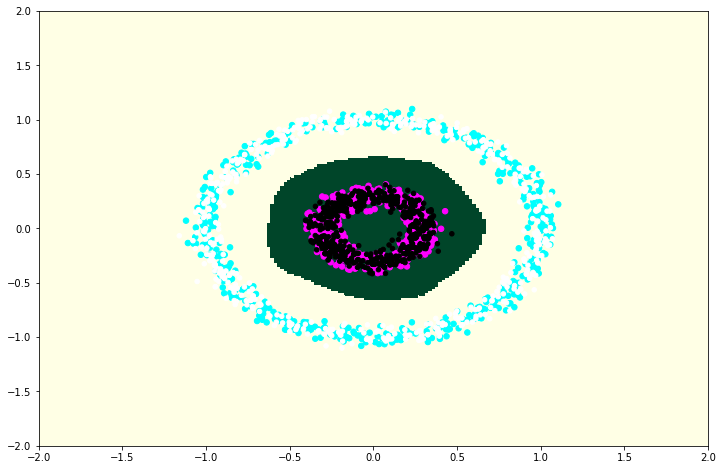

In [21]:
test_acc = [] 
train_acc = []
for i in range(1,6):
    n_h=2**i
    print ("Gráfico con "+str(n_h)+" neuronas en la capa escondida:")
    model = Sequential()
    model.add(Dense(n_h, input_dim=X_train.shape[1], kernel_initializer='uniform', activation='relu'))
    model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
    model.compile(optimizer=SGD(lr=1), loss='binary_crossentropy', metrics=['accuracy']) 

    model.fit(X_train, y_train, epochs=50, batch_size=100, verbose=0)
    scores = model.evaluate(X_test, y_test,verbose=0)
    test_acc.append(1-scores[1])
    scores = model.evaluate(X_train, y_train,verbose=0)
    train_acc.append(1-scores[1])
    plot_classifier(model,X_train,y_train,X_test,y_test,model_type = 'ann')



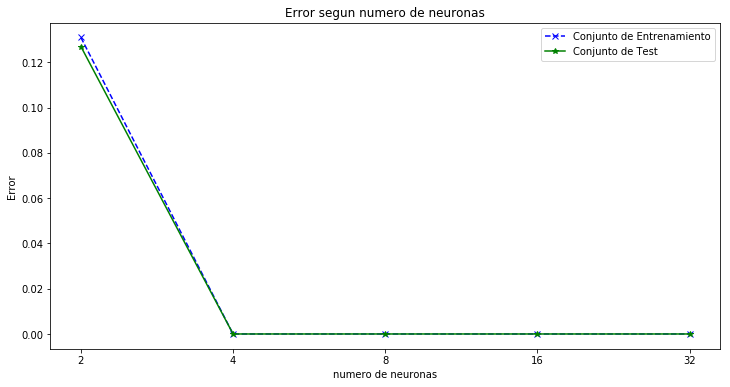

In [22]:
import matplotlib.pyplot as plt
N_h = [2,4,8,16,32]

plt.figure(figsize=(12,6))  
plt.title("Error segun numero de neuronas")
plt.xlabel("numero de neuronas")
plt.ylabel("Error")
indice = np.arange(5)   # Declara un array
plt.xticks(indice, N_h)   
#plt.yticks(np.arange(0.0,1.0,0.1))
plt.plot(train_acc, marker='x', linestyle='--', color='b', label = "Conjunto de Entrenamiento")
plt.plot(test_acc, marker='*', linestyle='-', color='g', label = "Conjunto de Test")
plt.legend(loc="upper right")
plt.show()

A partir del gráfico, podemos deducir que una capa oculta mejora notablemente las métricas, con una capa oculta de 2 neuronas ya se obtiene una *accuracy* de 86% en el conjunto de test, mayor que el 67% encontrado sin la capa oculta. Se puede observar por los gráficos de dispersión que la frontera generada con la capa oculta de 2 neuronas se puede ver casi lineal pero separa de alguna manera el círculo pequeño, esto sí, abarcando parte del círculo mayor. Esa es la razón por que no es 100%.

En comparación con la capa oculta con 2 neuronas, con 4,8,16 y 32 neurones se visualiza en los gráficos que el modelo puede diferenciar perfectamente el círculo pequeño con el grande y no queda ningún dato fuera del "área verde" que sería la predicción de la red, es por esta razón que se obtiene un 0% de error como se ve en el último gráfico de neuronas en función del error.

La capa oculta le da las capacidades a la red de resolver problemas no-lineales, es un modelo mucho más poderoso que el de la regresión logística ( símil a la red de 1 neurona ).

### d) Árbol de clasificación de un nivel

A continuación observaremos como se comporta un stump (árbol de clasificación de 1 nivel) para el problema anterior,
Para la ejecución del árbol se pueden modificar los siguientes parámetros:
* criterion: Mide la calidad de un split.
    * gini 
    * entropy
* splitter: Estrategia para elegir el split en cada nodo.
    * best
    * random
* max_depth: La profundidad máxima del árbol.


Se entrenará con ambos criterios para observar si hay algún cambio:

Test Accuracy Gini = 0.670000


c:\anaconda3\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


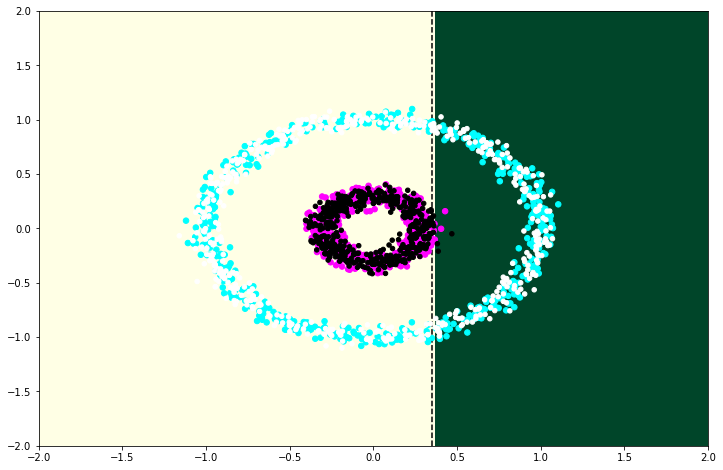

In [26]:
from sklearn.tree import DecisionTreeClassifier as Tree  #http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
clf_gini_best=Tree(criterion='gini',splitter='best',random_state=0,max_depth=1)
clf_gini_best.fit(X_train,y_train)
acc_test = clf_gini_best.score(X_test,y_test)
print("Test Accuracy Gini = %f"%acc_test)
plot_classifier(clf_gini_best,X_train,y_train,X_test,y_test,'tree')

Test Accuracy = 0.658000
1


c:\anaconda3\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


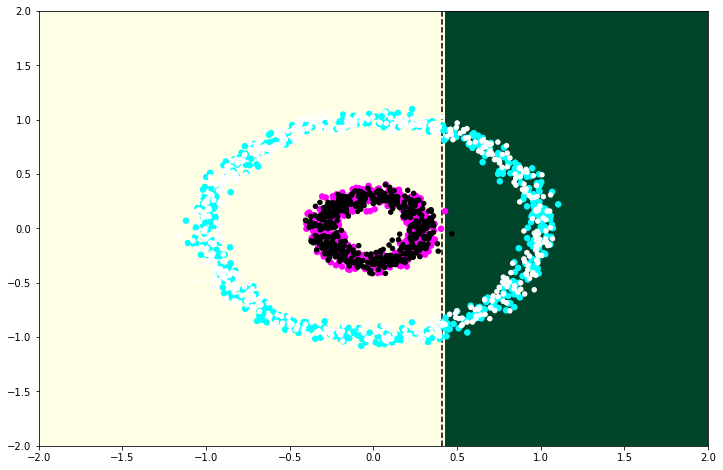

In [28]:
clf_entropy_best=Tree(criterion='entropy',splitter='best',random_state=0,max_depth=1)
clf_entropy_best.fit(X_train,y_train)
acc_test = clf_entropy_best.score(X_test,y_test)
print("Test Accuracy = %f"%acc_test)
print(clf_entropy_best.tree_.max_depth)
plot_classifier(clf_entropy_best,X_train,y_train,X_test,y_test,'tree')

Para los 2 criterios en general, se comportan muy parecido a la red neuronal con una única neurona, se obtiene valores de *accuracy* entre 60 y 70%.

Test Accuracy = 0.679000
1


c:\anaconda3\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


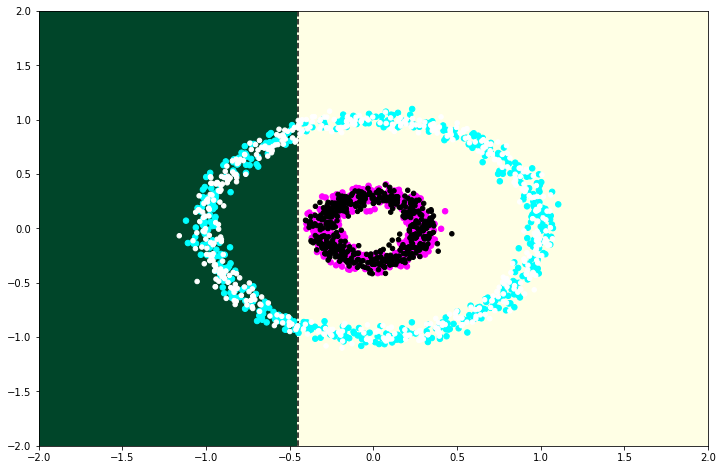

In [30]:
clf_gini_random=Tree(criterion='gini',splitter='random',random_state=0,max_depth=1)
clf_gini_random.fit(X_train,y_train)
acc_test = clf_gini_random.score(X_test,y_test)
print("Test Accuracy = %f"%acc_test)
print(clf_gini_random.tree_.max_depth)
plot_classifier(clf_gini_random,X_train,y_train,X_test,y_test,'tree')

Test Accuracy = 0.679000
1


c:\anaconda3\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


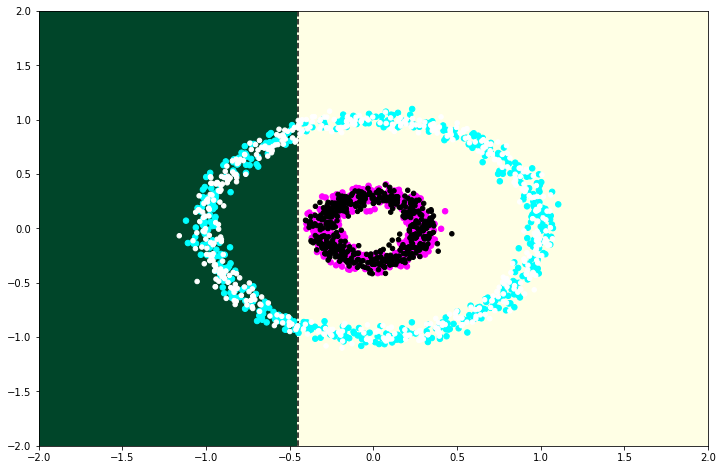

In [32]:
clf_entropy=Tree(criterion='entropy',splitter='random',random_state=0,max_depth=1)
clf_entropy.fit(X_train,y_train)
acc_test = clf_entropy.score(X_test,y_test)
print("Test Accuracy = %f"%acc_test)
print(clf_entropy.tree_.max_depth)
plot_classifier(clf_entropy,X_train,y_train,X_test,y_test,'tree')

En las últimas 2 celdas se utilizó el spliter "random", a pesar de eso, como es de esperar con un solo nivel del árbol no es posible resolver el problema que se tiene, pues el árbol de clasificación solo podrá dividir la región en dos. En general el *accuracy* vive en el rango de 60 a 70%.

### e) Árbol de clasificación con múltiples niveles

Análogo con la red neuronal con 1 neurona y sin capa oculta, se realiza el mismo árbol anterior pero ahora con más niveles. Esperando que pueda resolver satisfactoriamente el problema estudiado.

Nuevamente el problema se enfrenta con árboles de clasificación, pero en esta ocasión se hará con más de uno, variando entre 2 y 20 niveles.

Árbol con 2 niveles de profundidad :
Error test = 0.133000


c:\anaconda3\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


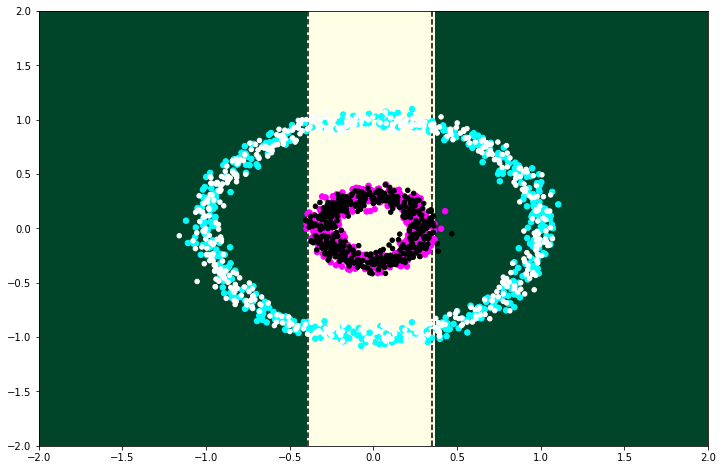

Árbol con 3 niveles de profundidad :
Error test = 0.076000


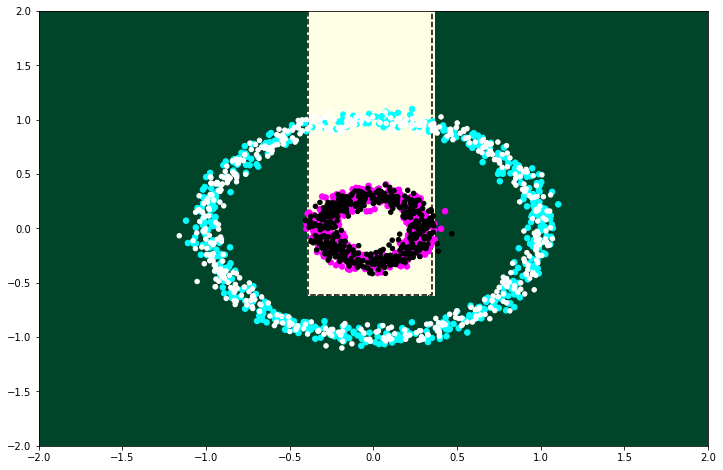

Árbol con 4 niveles de profundidad :
Error test = 0.006000


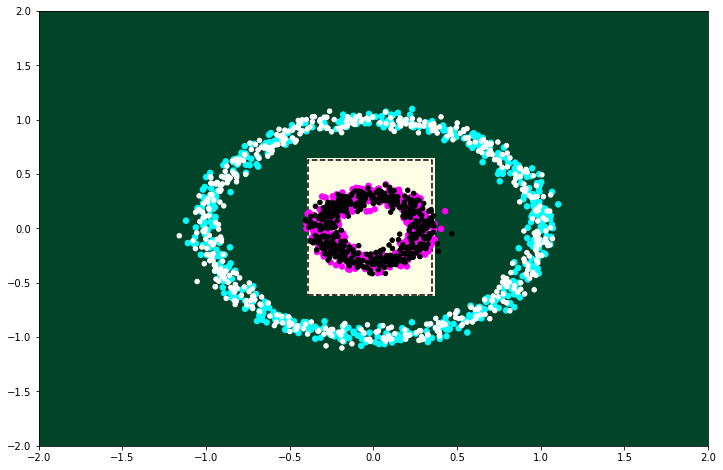

Árbol con 5 niveles de profundidad :
Error test = 0.008000


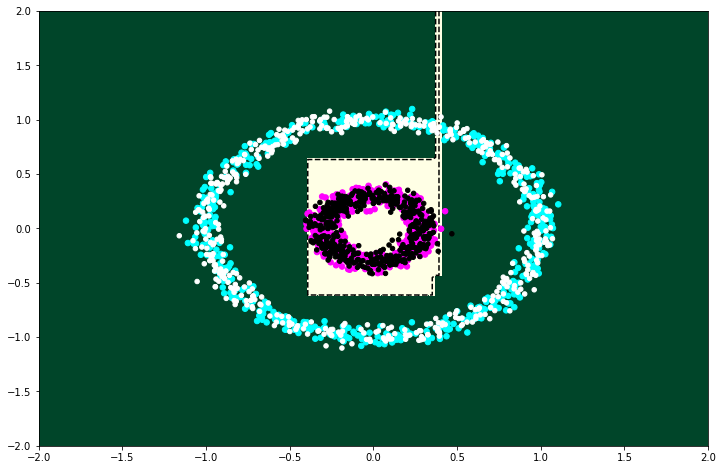

Árbol con 6 niveles de profundidad :
Error test = 0.008000


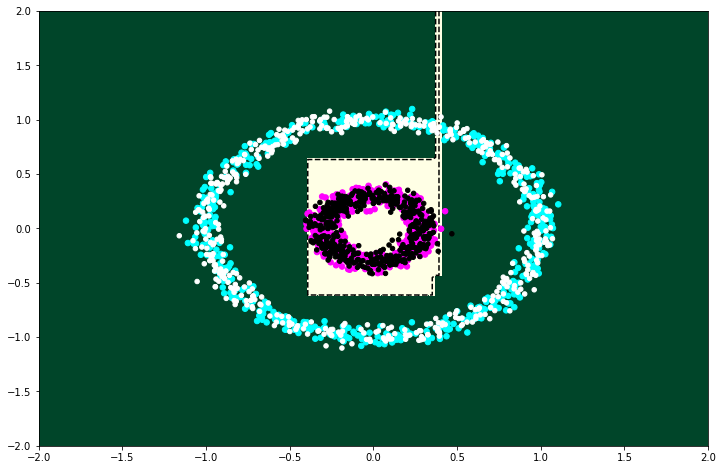

Árbol con 7 niveles de profundidad :
Error test = 0.008000


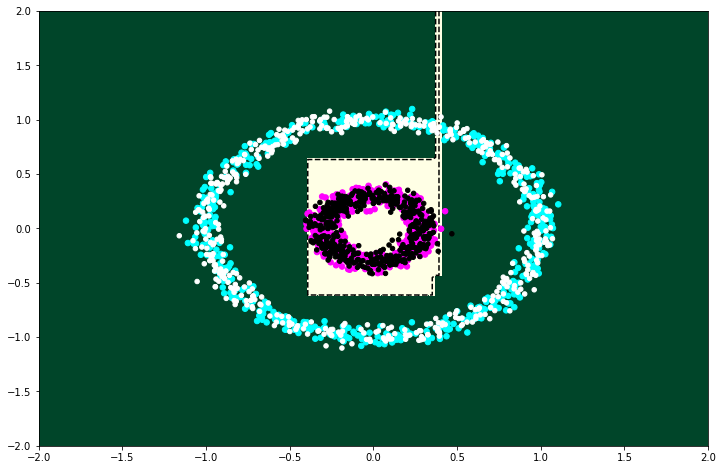

Árbol con 8 niveles de profundidad :
Error test = 0.008000


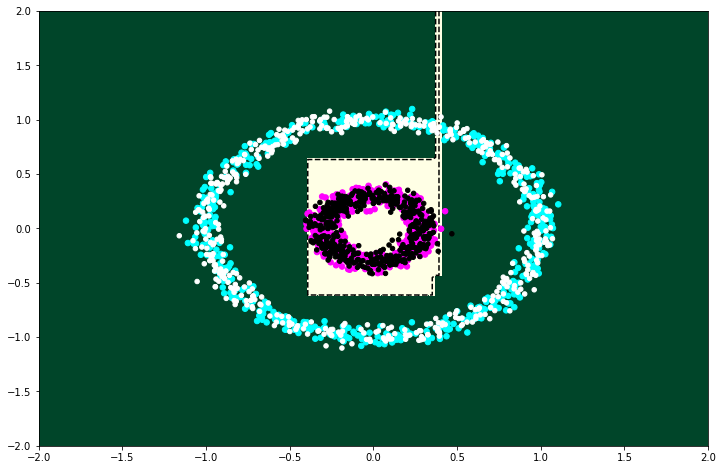

Árbol con 9 niveles de profundidad :
Error test = 0.008000


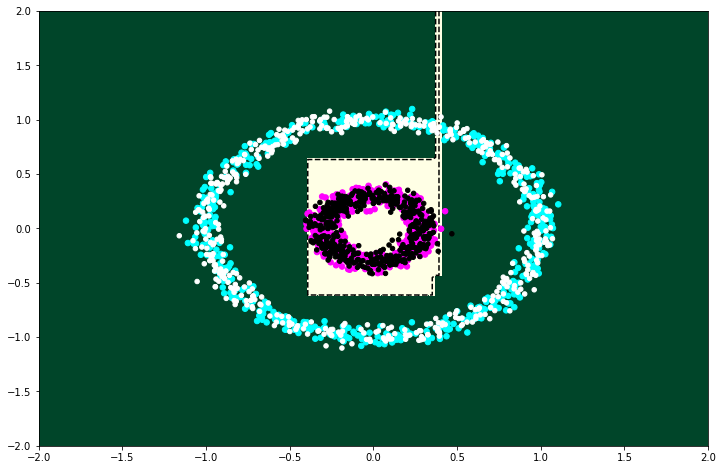

Árbol con 10 niveles de profundidad :
Error test = 0.008000


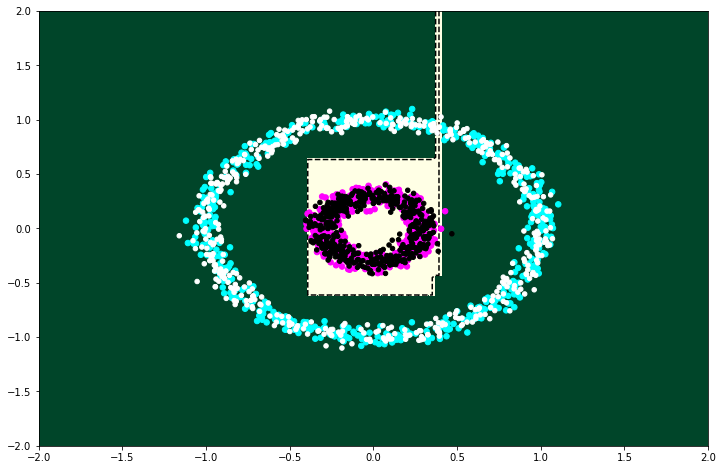

Árbol con 11 niveles de profundidad :
Error test = 0.008000


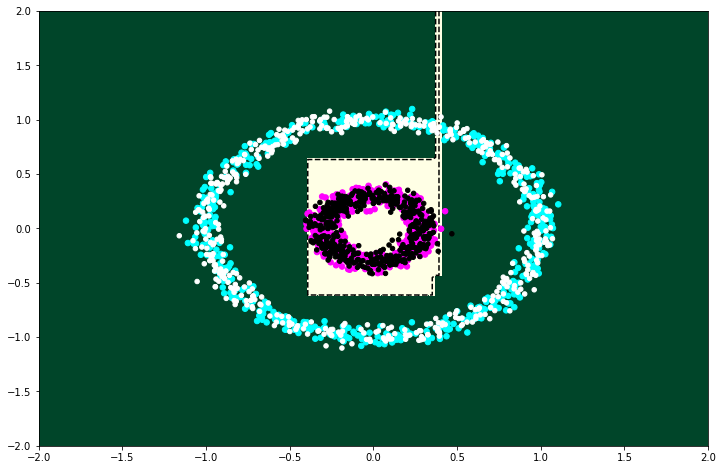

Árbol con 12 niveles de profundidad :
Error test = 0.008000


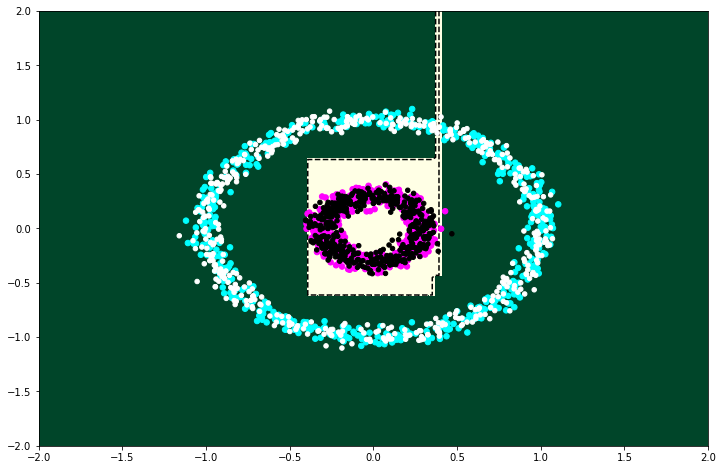

Árbol con 13 niveles de profundidad :
Error test = 0.008000


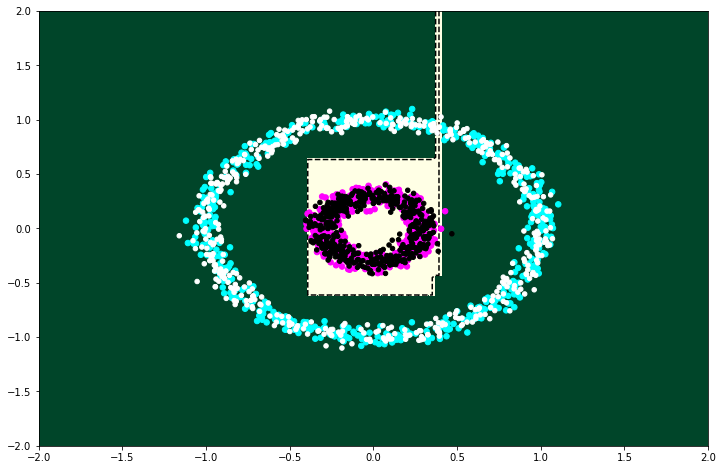

Árbol con 14 niveles de profundidad :
Error test = 0.008000


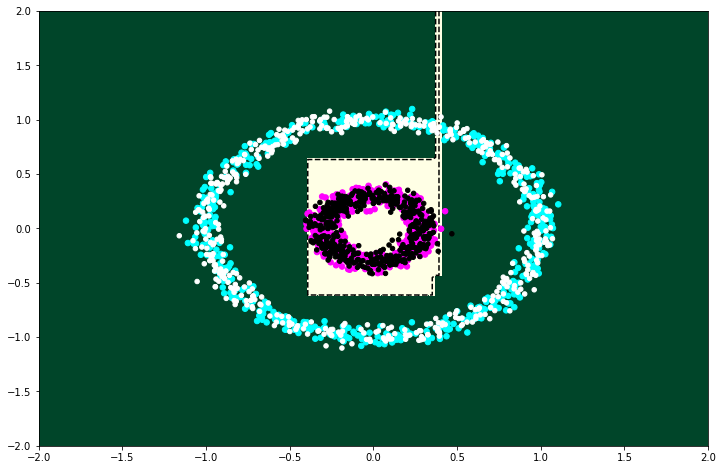

Árbol con 15 niveles de profundidad :
Error test = 0.008000


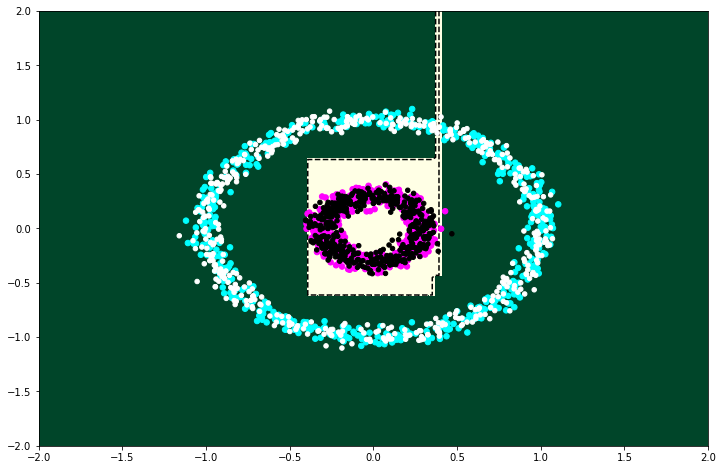

Árbol con 16 niveles de profundidad :
Error test = 0.008000


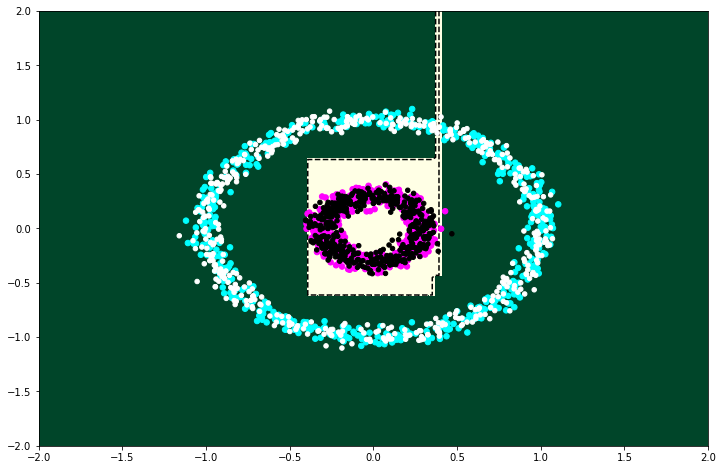

Árbol con 17 niveles de profundidad :
Error test = 0.008000


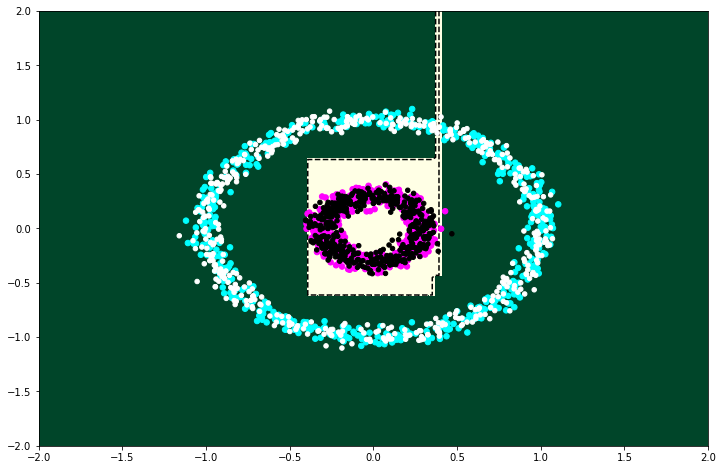

Árbol con 18 niveles de profundidad :
Error test = 0.008000


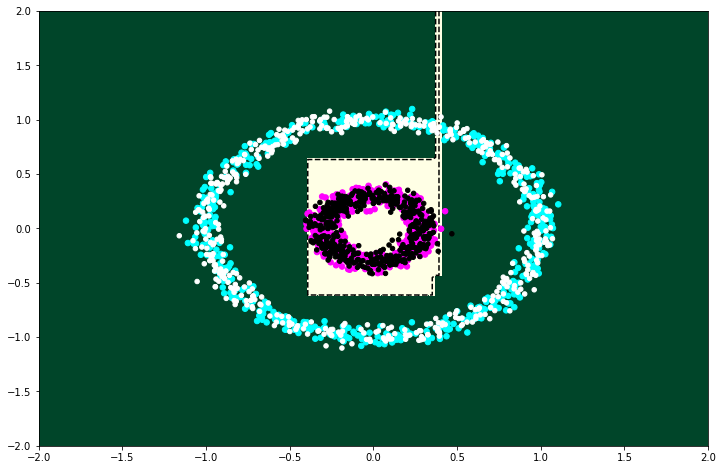

Árbol con 19 niveles de profundidad :
Error test = 0.008000


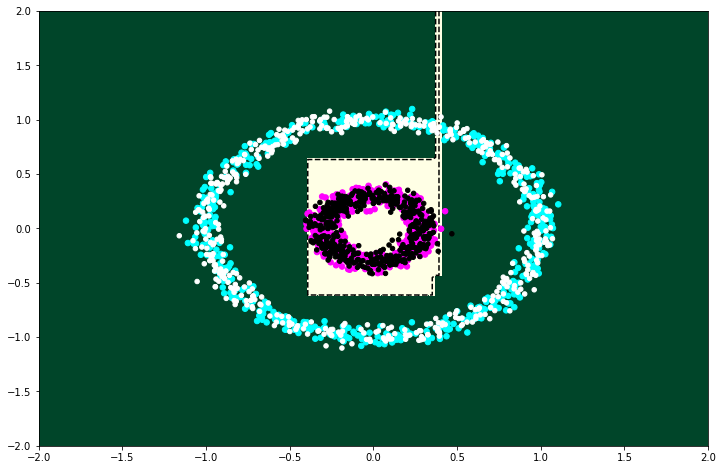

Árbol con 20 niveles de profundidad :
Error test = 0.008000


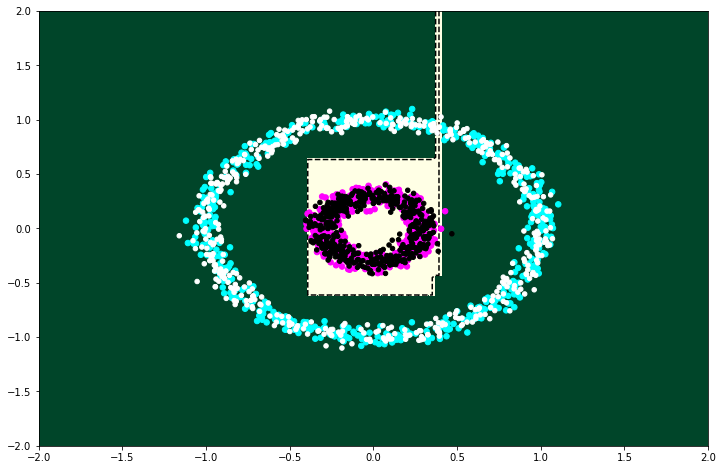

In [46]:
acc_test = []
acc_train = []
for i in range(2, 21):
    print("Árbol con "+str(i)+" niveles de profundidad :")
    n_t = i
    clf=Tree(criterion='gini',splitter='best',random_state=0,max_depth=n_t)
    clf.fit(X_train,y_train)
    acc_test.append(1-clf.score(X_test,y_test))
    acc_train.append(1-clf.score(X_train,y_train))
    print("Error test = %f"%acc_test[-1])
    plot_classifier(clf,X_train,y_train,X_test,y_test,'tree')

Es posible ver mediante las gráficas que el árbol de clasificación con más de un nivel permite dividir el espacio en más regiones, llegando al punto en que pueda separar correctamente el círculo interior del exterior. De hecho, ya con un árbol de nivel 4 logra cumplir con la tarea casi en su totalidad.

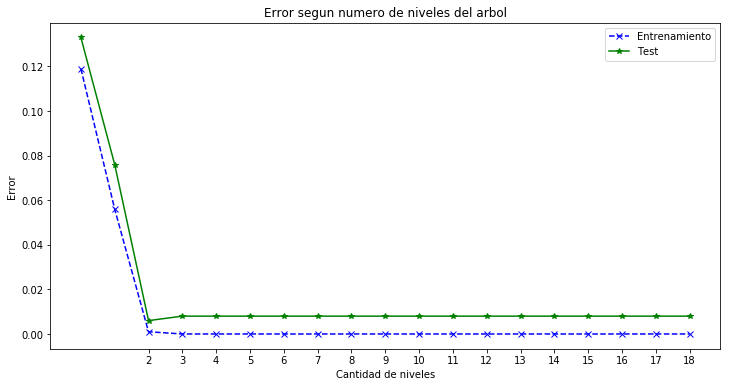

In [48]:
levels = range(2,21)

plt.figure(figsize=(12,6))  
plt.title("Error segun numero de niveles del arbol")
plt.xlabel("Cantidad de niveles")
plt.ylabel("Error")
plt.xticks(levels)   
plt.plot(acc_train, marker='x', linestyle='--', color='b', label = "Entrenamiento")
plt.plot(acc_test, marker='*', linestyle='-', color='g', label = "Test")
plt.legend(loc="best")
plt.show()

Este último gráfico se observa como a partir de la utilización de más de 1 nivel, el error se reduce drásticamente, esto como ya se explicó es por que el árbol multinivel permite separar el espacio en más regiones, consiguiendo así dividir o separar el círculo pequeño del círculo grande. Como toda máquina, también se puede visualizar el fenómeno de overfitting al evaluar el conjunto de test.

### f) PCA con kernel gaussiano

Dado que ya hemos comrobado que el problema no es linealmente separable, se realiza una una proyección de los datos a un nuevo espacio dimensional,en el cual se reconozcan los patrones no lineales, para luego poder trabajarlos con fronteras lineales. Para lograr lo anterior, se utiliza la técnica de PCA con la ayuda de un Kernel Gaussiano para extraer sus vectores con dimensión infinita de mayor varianza.

In [52]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components=2,kernel="rbf", gamma=5)
kpca = kpca.fit(X_train)
Xkpca_train = kpca.transform(X_train)
Xkpca_test = kpca.transform(X_test)

In [53]:
def visualize(x,y,title=""):
    fig = plt.figure(figsize=(12,6))
    plt.scatter(x[:,0], x[:,1], s=50, c=y, cmap=plt.cm.winter)
    h = .02 # step size in the mesh
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    plt.title(title)
    plt.show()

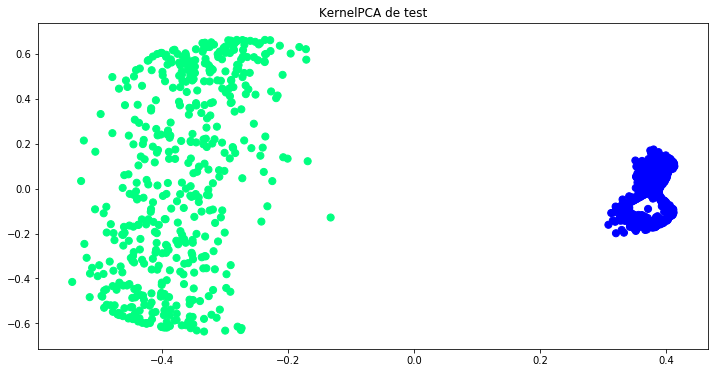

In [54]:
visualize(Xkpca_test, y_test, "KernelPCA de test")

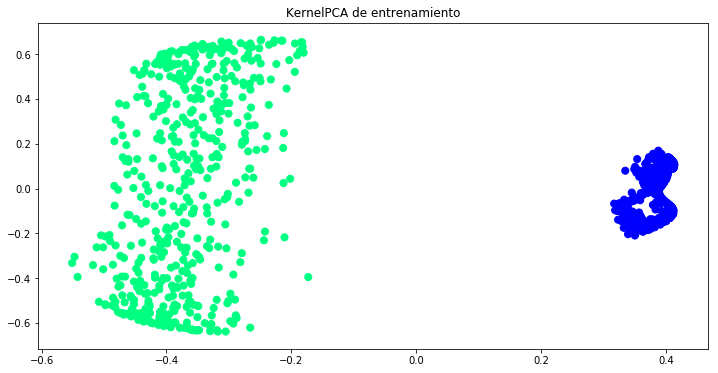

In [55]:
visualize(Xkpca_train, y_train, "KernelPCA de entrenamiento")

Luego, de aplicar Kernel PCA es pobile ver que en este nuevo espacio, los datos proyectados son separables linealmente.

### g) Algoritmo de aprendizaje con fronteras lineal para los datos proyectados

Dado que ya contamos con la proyección de lo datos en un nuevo espacio, en donde los datos son linealamente separables, se ajusta un modelo que trabaja con fronteras lineales para poder resolver este problema.

In [56]:
def visualize_border(model,x,y,title=""):
    fig = plt.figure(figsize=(12,6))
    plt.scatter(x[:,0], x[:,1], s=50, c=y, cmap=plt.cm.winter)
    h = .02 # step size in the mesh
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)
    plt.title(title)
    plt.show()

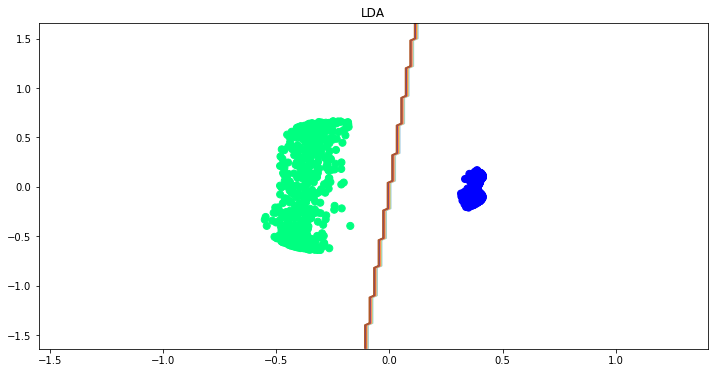

Miss Classification Loss: 0.000000
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       507
          1       1.00      1.00      1.00       493

avg / total       1.00      1.00      1.00      1000



In [58]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score, classification_report
model = LDA()
model.fit(Xkpca_train,y_train)
visualize_border(model,Xkpca_train,y_train,"LDA")

y_true = y_test
y_pred = model.predict(Xkpca_test)
model.predict(Xkpca_test)
print("Miss Classification Loss: %f"%(1-accuracy_score(y_true, y_pred)))
print(classification_report(y_true,model.predict(Xkpca_test)))

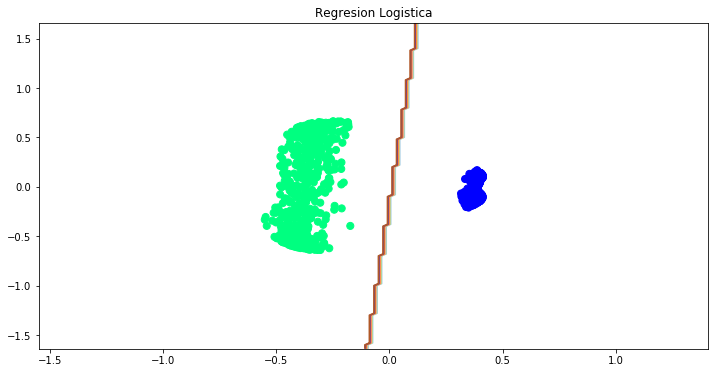

Accuracy train Regresion Logistica : 1.0
Accuracy test Regresion Logistica: 1.0
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       507
          1       1.00      1.00      1.00       493

avg / total       1.00      1.00      1.00      1000



In [60]:
from sklearn.linear_model import LogisticRegression as LR
clf_lr = LR()
clf_lr.set_params(penalty='l2')
clf_lr.fit(Xkpca_train,y_train)
predicted = clf_lr.predict(Xkpca_test)
predicted_train = clf_lr.predict(Xkpca_train)


visualize_border(clf_lr,Xkpca_train,y_train,"Regresion Logistica")

print("Accuracy train Regresion Logistica :",(accuracy_score(y_train,predicted_train)) )
print ("Accuracy test Regresion Logistica:",(accuracy_score(y_test,predicted)))
print(classification_report(y_true,clf_lr.predict(Xkpca_test)))

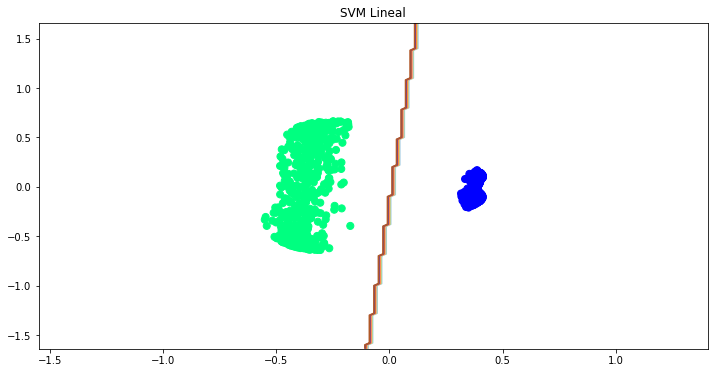

Accuracy train SVM : 1.0
Accuracy test SVM: 1.0
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       507
          1       1.00      1.00      1.00       493

avg / total       1.00      1.00      1.00      1000



In [61]:
from sklearn.svm import SVC as SVM
model= SVM()
model.set_params(C=0.01,kernel='linear')
model.fit(Xkpca_train,y_train)
predicted = model.predict(Xkpca_test)
predicted_train = model.predict(Xkpca_train)
visualize_border(clf_lr,Xkpca_train,y_train,"SVM Lineal")
print("Accuracy train SVM :",(accuracy_score(y_train,predicted_train)) )
print ("Accuracy test SVM:",(accuracy_score(y_test,predicted)))
print(classification_report(y_true,clf_lr.predict(Xkpca_test)))

Como se observó y esparaba, con estos algoritmos con fronteras lineales el problema es fácilmente separable luego de utilizar PCA con kernel gaussiano.